<a href="https://colab.research.google.com/github/ckheng78/DeepLearning/blob/master/%5BSubmission%5D_Chee_Kiang_Heng_DSTA_Jumpstart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Initialisation

In [0]:
! git clone https://github.com/mdda/colab_helper

Cloning into 'colab_helper'...
remote: Enumerating objects: 277, done.
remote: Total 277 (delta 0), reused 0 (delta 0), pack-reused 277
Receiving objects: 100% (277/277), 56.17 KiB | 639.00 KiB/s, done.
Resolving deltas: 100% (170/170), done.


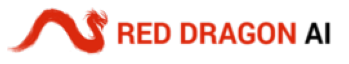

In [0]:
from colab_helper import utils as chu

In [0]:
! pip install kaggle

## Getting Dataset from Kaggle

In [0]:
chu.kaggle_credentials(username="totoro78", key="21012b2767dfca6022dd647db39f6000")

Credentials written to /root/.kaggle/kaggle.json


In [0]:
# Description page : https://www.kaggle.com/cfpb/us-consumer-finance-complaints
! kaggle datasets download cfpb/us-consumer-finance-complaints

 77% 65.0M/84.5M [00:01<00:01, 13.7MB/s]
100% 84.5M/84.5M [00:01<00:00, 46.1MB/s]


In [0]:
! unzip us-consumer-finance-complaints.zip
! rm us-consumer-finance-complaints.zip
! rm database.sqlite

Archive:  us-consumer-finance-complaints.zip
  inflating: consumer_complaints.csv  
  inflating: database.sqlite         


## Initialise modules - Start Here is the Runtime if still valid


In [0]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras import utils as np_utils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


## Load Data

In [0]:
d = pd.read_csv("consumer_complaints.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5,11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Understanding Dataset

In [0]:
d.head()

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,08/30/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,CA,95993,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511074
1,08/30/2013,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,91104,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511080
2,08/30/2013,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,Wells Fargo & Company,NY,11764,NaN,NaN,Postal mail,09/18/2013,Closed with explanation,Yes,No,510473
3,08/30/2013,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,NaN,NaN,"Navient Solutions, Inc.",MD,21402,NaN,NaN,Email,08/30/2013,Closed with explanation,Yes,Yes,510326
4,08/30/2013,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,NaN,NaN,Resurgent Capital Services L.P.,GA,30106,NaN,NaN,Web,08/30/2013,Closed with explanation,Yes,Yes,511067


In [0]:
print(d.shape)
print(d.columns)

(555957, 18)
Index(['date_received', 'product', 'sub_product', 'issue', 'sub_issue',
       'consumer_complaint_narrative', 'company_public_response', 'company',
       'state', 'zipcode', 'tags', 'consumer_consent_provided',
       'submitted_via', 'date_sent_to_company', 'company_response_to_consumer',
       'timely_response', 'consumer_disputed?', 'complaint_id'],
      dtype='object')


In [0]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555957 entries, 0 to 555956
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   date_received                 555957 non-null  object
 1   product                       555957 non-null  object
 2   sub_product                   397635 non-null  object
 3   issue                         555957 non-null  object
 4   sub_issue                     212622 non-null  object
 5   consumer_complaint_narrative  66806 non-null   object
 6   company_public_response       85124 non-null   object
 7   company                       555957 non-null  object
 8   state                         551070 non-null  object
 9   zipcode                       551452 non-null  object
 10  tags                          77959 non-null   object
 11  consumer_consent_provided     123458 non-null  object
 12  submitted_via                 555957 non-null  object
 13 

## Data Preparation

In [0]:
# get what we need
df = d[['product', 'consumer_complaint_narrative']]
df.head()

,product,consumer_complaint_narrative
0,Mortgage,NaN
1,Mortgage,NaN
2,Credit reporting,NaN
3,Student loan,NaN
4,Debt collection,NaN


In [0]:
# we cannot classify empty complaint so we need to remove them
df = df.dropna()
df.head()

,product,consumer_complaint_narrative
190126,Debt collection,XXXX has claimed I owe them {$27.00} for XXXX ...
190135,Consumer Loan,Due to inconsistencies in the amount owed that...
190155,Mortgage,In XX/XX/XXXX my wages that I earned at my job...
190207,Mortgage,I have an open and current mortgage with Chase...
190208,Mortgage,XXXX was submitted XX/XX/XXXX. At the time I s...


In [0]:
# check the number of classes
classes = np.unique(df['product'])
num_classes = len(classes)
print("There are ", len(classes), " classes and they are = ", classes)

There are  11  classes and they are =  ['Bank account or service' 'Consumer Loan' 'Credit card'
 'Credit reporting' 'Debt collection' 'Money transfers' 'Mortgage'
 'Other financial service' 'Payday loan' 'Prepaid card' 'Student loan']


In [0]:
# extract products from df as an array
y_products = df.iloc[:, 0].values
# extract consumer complaints as an array
x_complaints = df.iloc[:, 1].values

print("y_products shape", y_products.shape)
print("x_complaints shape", x_complaints.shape)

y_products shape (66806,)
x_complaints shape (66806,)


## Text Preprocessing

In [0]:
 # Encode consumer complaints with sequence numbers
tk = Tokenizer(num_words = 200, filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',lower = True, split = " ")
tk.fit_on_texts(x_complaints)
x_complaints_input = tk.texts_to_sequences(x_complaints)
x_complaints_input = sequence.pad_sequences(x_complaints_input, maxlen = 200)

print(x_complaints_input)

[[  0   0   0 ...   3  84 108]
 [  0   0   0 ...   2   8   6]
 [145  10 112 ...   7   9   7]
 ...
 [  0   0   0 ... 171  66   1]
 [  0   0   0 ...   2 150  68]
 [ 32   2   4 ...   5  24  16]]


In [0]:
# Encode products as label (need to convert to numerics)
le_products = LabelEncoder()
y_products_output = le_products.fit_transform(y_products)
print(y_products_output)
# print out unique label and its count
print(np.unique(y_products_output, return_counts=True))

[4 1 6 ... 8 6 6]
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([ 5711,  3678,  7929, 12526, 17552,   666, 14919,   110,   726,
         861,  2128]))


In [0]:
# num_classes was declared earlier
y_products_classes = y = np_utils.to_categorical(y_products_output, num_classes= num_classes)
print(y_products_classes)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## Training / Testing Data Generation

In [0]:
x_complaints_input_1, y_products_classes_1 = shuffle(x_complaints_input, y_products_classes, random_state=42)

split = 0.8

x_train, x_test, y_train, y_test = train_test_split(x_complaints_input_1, y_products_classes_1, test_size=0.1, random_state=42)

# training dataset
print("Training dataset shape")
print(x_train.shape, y_train.shape)
# testing dataset
print("Testing dataset shape")
print(x_test.shape, y_test.shape)

Training dataset shape
(60125, 200) (60125, 11)
Testing dataset shape
(6681, 200) (6681, 11)


In [0]:
x_train_p = sequence.pad_sequences(x_train, maxlen=201)
x_test_p = sequence.pad_sequences(x_test, maxlen=201)
print('x_train_p shape:', x_train_p.shape)
print('x_test_p shape:', x_test_p.shape)

x_train_p shape: (60125, 201)
x_test_p shape: (6681, 201)


## Data Pipeline

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding, LSTM
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D

max_features = 1000
maxlen = 201
embedding_dims = 50
filters = 250
kernel_size = 3
hidden_dims = 250

# CNN with max pooling imeplementation 
model = Sequential()
# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
model.add(Embedding(max_features,
                    embedding_dims,
                    input_length=maxlen))
model.add(Dropout(0.2))

# we add a Convolution1D, which will learn filters
# word group filters of size filter_length:
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
# we use max pooling:
# model.add(GlobalMaxPooling1D())
model.add(MaxPooling1D(pool_size=4))

# added LSTM
model.add(LSTM(250))

# We add a vanilla hidden layer:
model.add(Dense(hidden_dims))
model.add(Dropout(0.2))
model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(11))
model.add(Activation('softmax'))

## Model Building

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 201, 50)           50000     
_________________________________________________________________
dropout_5 (Dropout)          (None, 201, 50)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 199, 250)          37750     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 49, 250)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 250)               501000    
_________________________________________________________________
dense_5 (Dense)              (None, 250)               62750     
_________________________________________________________________
dropout_6 (Dropout)          (None, 250)              

## Training

In [0]:
# tried out with 50 epochs but accuracy > val_accuracy consistently after 15 epoch, trying out 15 instead
# tried again with 15 but it become consistently accuracy > val_accuracy after 12 epoch
# trying 10 epoch
model.fit(x_train_p, y_train,
          batch_size = 128,
          epochs = 10,
          validation_data=(x_test_p, y_test))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 60125 samples, validate on 6681 samples
Epoch 1/10
60125/60125 [==============================] - 43s 707us/step - loss: 1.3471 - accuracy: 0.5466 - val_loss: 1.0088 - val_accuracy: 0.6747
Epoch 2/10
60125/60125 [==============================] - 42s 700us/step - loss: 0.9846 - accuracy: 0.6800 - val_loss: 0.9020 - val_accuracy: 0.7105
Epoch 3/10
60125/60125 [==============================] - 42s 701us/step - loss: 0.9046 - accuracy: 0.7014 - val_loss: 0.8734 - val_accuracy: 0.7128
Epoch 4/10
60125/60125 [==============================] - 41s 680us/step - loss: 0.8646 - accuracy: 0.7138 - val_loss: 0.8538 - val_accuracy: 0.7177
Epoch 5/10
60125/60125 [==============================] - 42s 698us/step - loss: 0.8352 - accuracy: 0.7231 - val_loss: 0.8119 - val_accuracy: 0.7339
Epoch 6/10
60125/60125 [==============================] - 41s 690us/step - loss: 0.8129 - accuracy: 0.7297 - val_loss: 0.8553 - val_accuracy: 0.7134
Epoch 7/10
60125/60125 [==============================] -

## Evaluate Model

In [0]:
model.evaluate(x=x_test_p, y=y_test, batch_size = 128)

6681/6681 [==============================] - 0s 71us/step


[0.7932066430661551, 0.7512348294258118]

## Predict

In [0]:
offset = np.random.randint(low=1, high=100, size=1)[0]
for i in range(10):
  j = offset + i
  x_to_predict = x_test_p[j:j+1,:]
  print("j = ", j, " predicted: ", np.argmax(model.predict(x_to_predict)), " actual = ", np.argmax(y_test[j]))


j =  4  predicted:  2  actual =  2
j =  5  predicted:  10  actual =  10
j =  6  predicted:  1  actual =  6
j =  7  predicted:  3  actual =  4
j =  8  predicted:  6  actual =  6
j =  9  predicted:  6  actual =  6
j =  10  predicted:  3  actual =  9
j =  11  predicted:  4  actual =  4
j =  12  predicted:  1  actual =  8
j =  13  predicted:  3  actual =  4
